# Семинар 5: Transfer Learning, Adversarial Attacks, Deep Network Visualization

## Вступление
Сегодня мы продолжим работать с изображениями при помощи нейросетей. Сперва узнаем, как потратить мало вычислительных ресурсов, чтобы при наличии модели для одной задачи, научиться решат новую задачу. Затем посмотрим на то, как можно за один шаг обучения сбивать нейросети с толку на некоторых примерах. В конце семинара будем визуализировать работу свёрточных сетей.

Этот ноутбук, в отличие от предыдущих, очень рекомендуется исполнять в Google Colab или похожих платформах, чтобы всю работало побыстрее.

### План семинара
1. Изучаем transfer learning на примере файнтюнинга ResNet
2. Изучаем adversarial attacks на примере Fast Gradient Sign Attack
3. Визуализируем слои свёрточной сети при помощи Shapley Additive Explanations

In [1]:
import glob
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

%matplotlib inline
warnings.filterwarnings("ignore")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

## 1. Изучаем transfer learning на примере файнтюнинга ResNet

В этой секции мы научимся очень быстро обучать нейросеть на сложную задачу классификации изображений. А именно, научим нейросеть отличать кошечек от собачек.

### Данные

Скачем датасет, удалим пару битых картинок и подготовим лоадеры.

In [2]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -qq kagglecatsanddogs_5340.zip
!rm -rf PetImages/Cat/666.jpg PetImages/Dog/11702.jpg readme\[1\].txt CDLA-Permissive-2.0.pdf

--2023-12-17 17:34:28--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.245.101, 2a02:26f0:fe00:295::317f, 2a02:26f0:fe00:28f::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.36.245.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   118MB/s    in 6.4s    

2023-12-17 17:34:34 (122 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [4]:
dataset = ImageFolder(
    "./PetImages",
    transform=Compose(
        [
            Resize((224, 224)),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)),
        ]
    ),
)
train_set, val_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)

Посмотрим, как выглядят картинки.

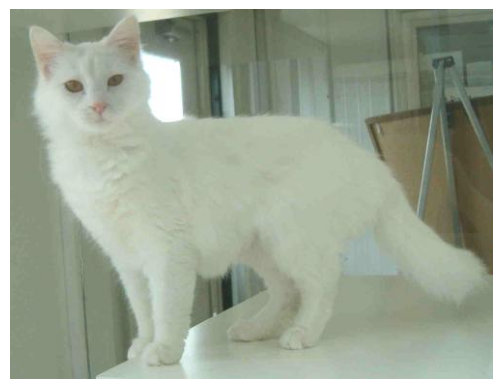

In [5]:
file = np.random.choice(glob.glob("./PetImages/*/*.jpg"))
plt.axis("off")
plt.imshow(plt.imread(file));

### Fine-tuning

Кошки и собаки — это, конечно, хорошо, вот только обучение модели, которая будет хорошо работать на этом датасете может оказаться очень долгим...

Однако картинки, которые мы сегодня рассмотрим, оказываются очень похожими на картинки из огромного датасета ImageNet. Задача, которую мы сегодня рассмотрим, называется Transfer Learning. Знания мы действительно переносим — от сети, которая хорошо работает на одном датасете (ImageNet) к другим данным (к датасету Cats vs Dogs).

#### Загрузим уже обученную сеть

В библиотеке `torchvision` имплементировано не только большое множество моделей (всевозможные ResNet'ы, Inception, VGG, AlexNet, DenseNet, ResNext, WideResNet, MobileNet...), но и загружены чекпоинты обучения этих моделей на ImageNet. Однако для датасета Cats vs Dogs такая штука является роскошью...

In [6]:
!pip install pytorch_lightning torchmetrics torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 17.2 MB/s eta 0:00:00


In [7]:
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torchvision.models import resnet18

In [8]:
model = resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

В задаче transfer learning'a мы заменяем последний слой нейросети на линейный с двумя выходами, а веса остальных слоёв "замораживаем".

In [9]:
class CatsVSDogsResnet(pl.LightningModule):
    def __init__(self, pretrained: bool = False) -> None:
        super().__init__()
        self.pretrained = pretrained

        if pretrained:
            # <YOUR CODE HERE>
            self.model = resnet18(pretrained=True)
            self.model.fc = nn.Identity()
            self.classifier = nn.Linear(512, 2)
            self.optimizer = torch.optim.Adam(self.classifier.parameters())
        else:
            # <YOUR CODE HERE>
            self.model = resnet18(pretrained=False)
            self.model.fc = nn.Linear(self.model.fc.in_features, 2)
            self.optimizer = torch.optim.Adam(self.model.parameters())

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        if self.pretrained:
            # <YOUR CODE HERE>
            with torch.no_grad():
                features = self.model(x)
            preds = self.classifier(features)
        else:
            # <YOUR CODE HERE>
            preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task = 'binary')
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

Запустим transfer learning!

In [10]:
cats_vs_dogs_pretrained = CatsVSDogsResnet(pretrained=True)

trainer = pl.Trainer(accelerator="auto", max_epochs=1)
trainer.fit(cats_vs_dogs_pretrained, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 11.2 M
1 | classifier | Linear           | 1.0 K 
2 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Уже после одной эпохи получается приемлемое качество! Давайте проверим, что получится, если учить ResNet с нуля.

In [ ]:
cats_vs_dogs = CatsVSDogsResnet(pretrained=False)

trainer = pl.Trainer(accelerator="auto", max_epochs=1)
trainer.fit(cats_vs_dogs, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Как мы видим, на transfer learning'e нейросеть сходится очень быстро. Значительно быстрее, чем инициализированная с нуля. Можно с уверенностью говорить, что transfer learning — очень полезная техника.

## 2. Изучаем adversarial attacks на примере Fast Gradient Sign Attack

Такая вещь, как атаки на нейросеть крайне важны для учёта при разработке. Существует много методов как их генерации, так и защиты от них. Мы рассмотрим сегодня базовые концепты, чтобы дать понимание происходящего.

Можем назвать adversarial атакой генерацию такого примера, который не отличим глазом от настоящего, но нейросеть будет ОЧЕНЬ уверена в том, что этот пример из другого класса. Сейчас мы попробуем сгенерировать такую собачку, что нейросеть будет уверена, что это котик.

Сегодня мы рассмотрим пример Fast Gradient Sign Attack (FGSM, почему там буква M в конце — чёрт его знает...). Идея очень простая. Оказывается, что если мы через обученную нейросеть посчитаем градиент по исходной картинке, посчитаем его знак и прибавим, умножив на маленькое число, модель подумает, что это картинка другого класса.

<img src="https://pytorch.org/tutorials/_images/fgsm_panda_image.png">

In [12]:
def fgsm_attack(
    original_image: torch.Tensor, epsilon: float, data_grad: torch.Tensor
) -> torch.Tensor:
    # <YOUR CODE HERE>
    perturbated_image = original_image + epsilon * torch.sign(data_grad)
    return perturbated_image

In [13]:
model = nn.Sequential(cats_vs_dogs_pretrained.model, cats_vs_dogs_pretrained.classifier)
model.eval()
for param in model.parameters():
    param.requires_grad = True

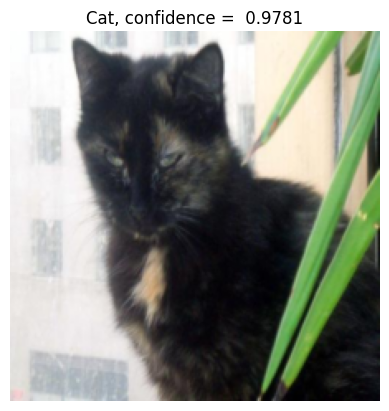

In [14]:
while True:
    # ищем кошку
    idx = np.random.randint(0, len(train_set))
    if train_set[idx][1] != 0:
        continue
    cat_image = train_set[idx][0]
    break

# Разрешим вычисление градиента по картинке
cat_image.requires_grad = True

pred = model(cat_image[None])
predicted_label = pred.argmax(1).item()
confidence = pred.softmax(1)[0][predicted_label]
if predicted_label == 1:
    plt.title("Dog, confidence = %0.4f" % confidence.item())
else:
    plt.title("Cat, confidence =  %0.4f" % confidence.item())
plt.axis("off")
plt.imshow(cat_image.cpu().detach().numpy().transpose((1, 2, 0)) + 0.5);

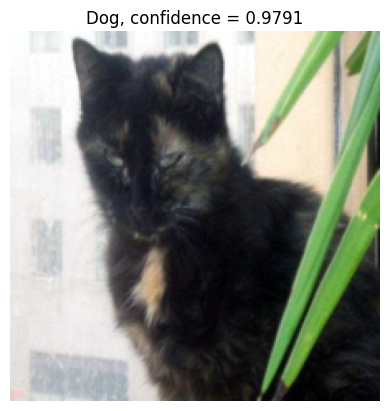

In [15]:
loss = nn.CrossEntropyLoss()(pred, torch.tensor(0).reshape((1,)))
loss.backward()

eps = 0.007

cat_image_perturbated = fgsm_attack(cat_image, eps, cat_image.grad)
pred = model(cat_image_perturbated[None])
predicted_label = pred.argmax(1).item()
confidence = pred.softmax(1)[0][predicted_label]

plt.axis("off")
if predicted_label == 1:
    plt.title("Dog, confidence = %0.4f" % confidence.item())
else:
    plt.title("Cat, confidence =  %0.4f" % confidence.item())
plt.imshow(cat_image_perturbated.cpu().detach().numpy().transpose((1, 2, 0)) + 0.5);

Самое интересное начинается тут. Вычислим градиент функции потерь по картинке и произведём атаку.

## 3. Визуализируем слои свёрточной сети при помощи Shapley Additive Explanations

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.svg" />

**SHAP (SHapley Additive exPlanations)** is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

Представим, что предсказание - результат командной игры и нужно понять, какой вклад в какое место результат внес каждый игрок(фича).

Вклад каждой фичи измеряется так называемой **Shapley value** - понятием из **cooperative game theory**, описывающим вклад фичи в предсказание.

Например, вы снимаете однушку в Москве и хотите создать модель, которая предскажет стоимость выбранного вами варианта. Для заданной квартиры модель предсказала цену 50.000 р. Свойства квартиры, по которой была предсказана цена: в пределах мкада, есть кондиционер, с домашними крокодилами нельзя, рядом находится парк. Нужно найти **Shapley value** свойства "с крокодилами нельзя", чтобы понять, насколько большой вклад вносит именно этот признак.

**Shapley value** это среднее от возможных **marginal contributions**. Мы создаем все возможные наборы над множеством свойств, исключая интересующее ("с крокодилами нельзя"):


*   ни одного свойства
*   в пределах мкада
*   кондей
*   рядом парк
*   в пределах мкада, кондей
*   в пределах мкада, рядом парк
*   кондей, рядом парк
*   в пределах мкада, рядом парк, кондей


Пример для маржинального вклада:

**Marginal contribution** = *model_predict* (в пределах мкада, рядом парк, с крокодилами нельзя) -  *model_predict* (в пределах мкада, рядом парк)

$$
\Phi(v)_i=\sum_{K \ni i} \frac{(k-1) !(n-k) !}{n !}(v(K)-v(K \backslash i))
$$

Где: $n$ — количество игроков (в нашем случае это признаки модели). $v$ — предсказание модели на наборе признаков. $k$ — количество участников коалиции $K$.

Предсказание можно объяснить, предположив, что каждый признак является “игроком” в игре, где предсказание является выплатой. Значения Шепли — метод из теории коалиционных игр — подсказывает нам, как справедливо распределить “выплату” между признаками.

Документация по [cсылкe](https://shap.readthedocs.io/en/latest/).


In [16]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.6 MB/s eta 0:00:00


In [17]:
import json

import shap

### Изучаем слои ResNet на данных ImageNet

Трактовка предсказаний на основе оригинальной картинки проще, чем на основе слоёв, которые ближе всего к выходу сети, потому что последние менее интерпретируемы. Каждый уровень в deep CNN изучает фильтры возрастающей сложности. На первых слоях изучаются основные фильтры обнаружения объектов, такие как края и углы. Средние слои изучают фильтры, которые обнаруживают части объектов — что касается лиц, они могут научиться реагировать на глаза и носы. Последние слои имеют более высокие представления: они учатся распознавать объекты целиком, в различных формах и положениях.

Мы рассмотрим модель GradientExplainer, которая использует ожидаемые градиенты для оценки входов в разные части модели. В целом, они аппроксимируют значения SHAP. Будем брать 50 семплов для подсчёта ожидаемых градиентов и посмотрим на признаки первых слоёв ResNet.

In [18]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll axes so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

In [19]:
# Load proper model (resnet50) and data (imagenet50) from Shap wrapper
model = resnet18(pretrained=True).eval()
X, y = shap.datasets.imagenet50()
X /= 255

to_explain = X[[1, 41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)

with open(fname) as f:
    class_names = json.load(f)

#### Layer 1

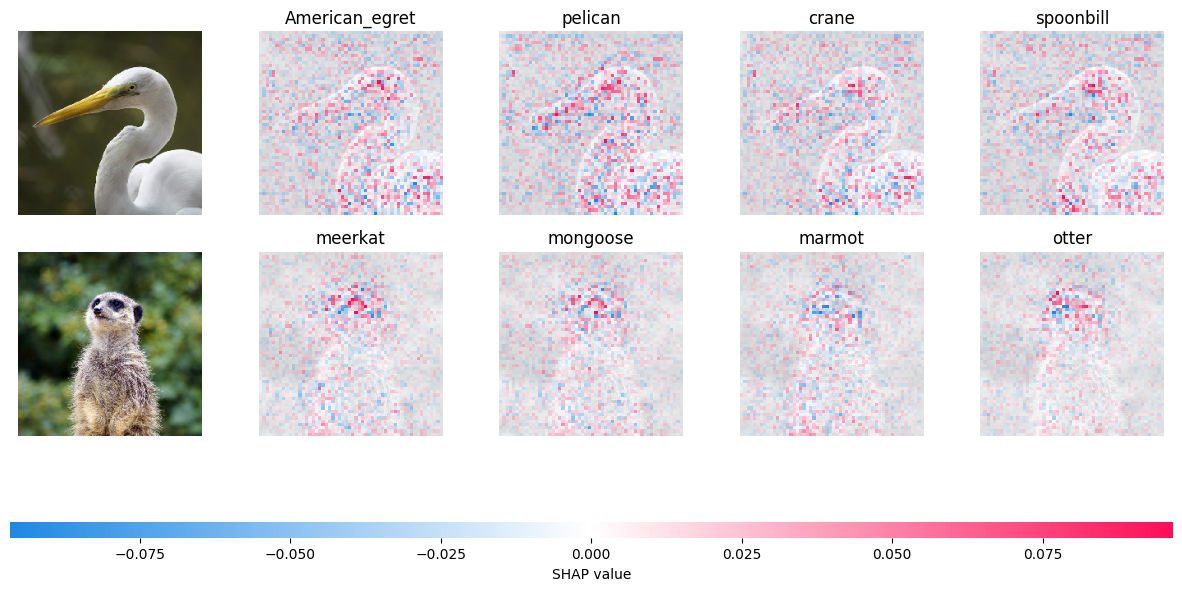

In [20]:
# create GradientExplainer object for convolution layer from Resnet Layer1
e = shap.GradientExplainer((model, model.layer1[0].conv2), normalize(X))
# receive shap_values
shap_values, indexes = e.shap_values(
    normalize(to_explain), ranked_outputs=4, nsamples=50
)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

#### Layer 2

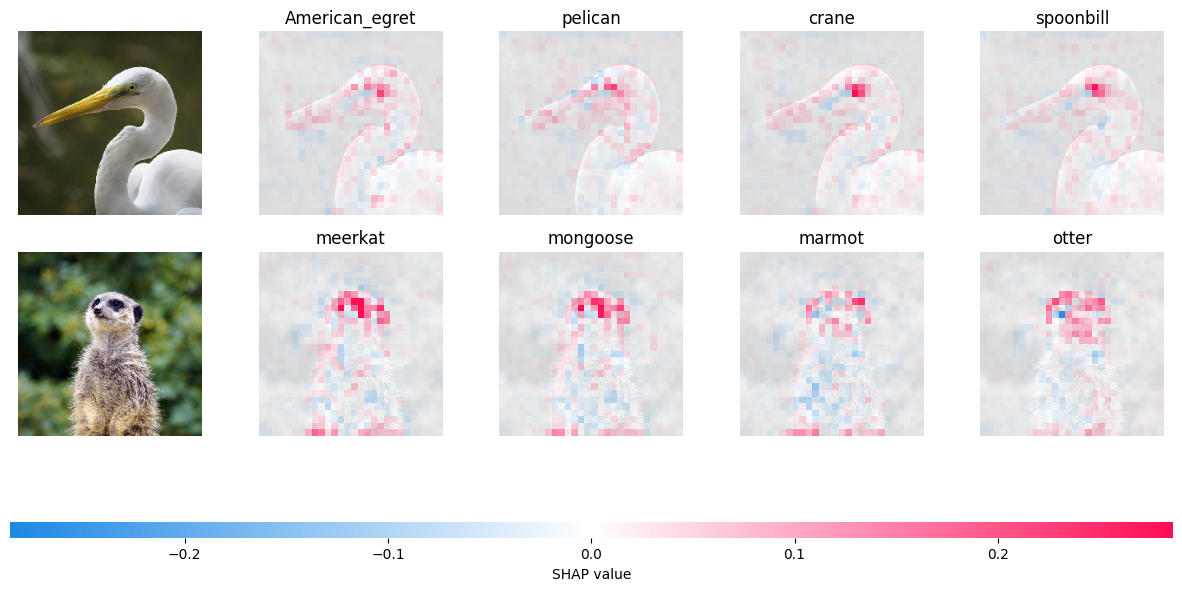

In [21]:
e = shap.GradientExplainer((model, model.layer2[0].conv2), normalize(X))
shap_values, indexes = e.shap_values(
    normalize(to_explain), ranked_outputs=4, nsamples=50
)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, to_explain, index_names)

#### Layer 4

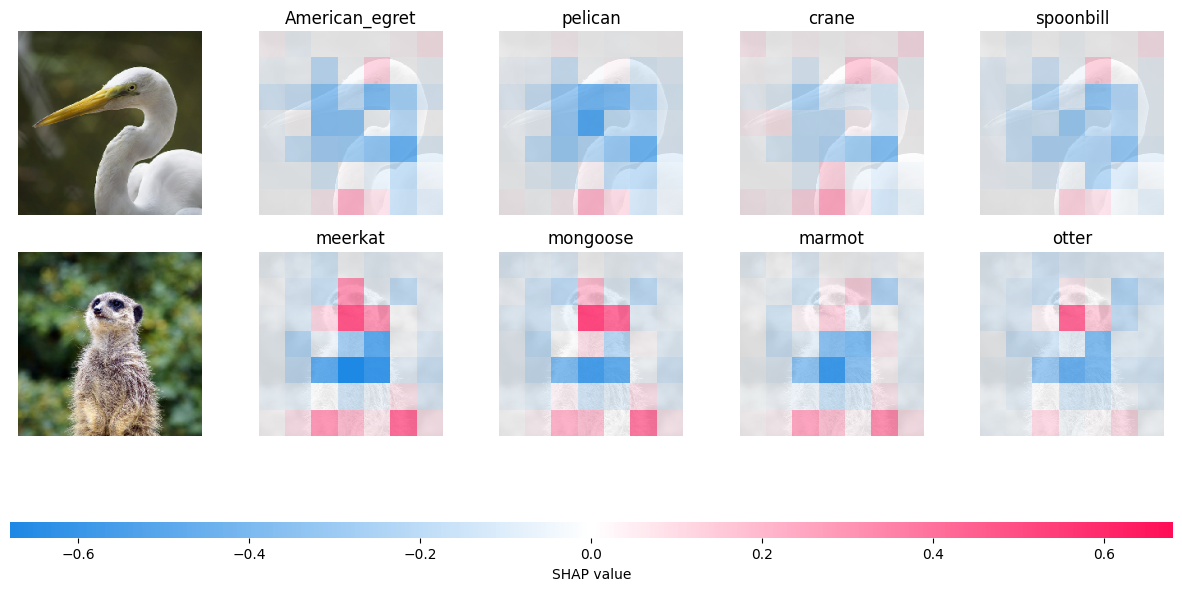

In [22]:
e = shap.GradientExplainer((model, model.layer4[0].conv2), normalize(X))
shap_values, indexes = e.shap_values(
    normalize(to_explain), ranked_outputs=4, nsamples=50
)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, to_explain, index_names)